Hunter Bennett | Glass Lab | 15 June 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
# dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

# save dict to convert columns to integers
convert_dict = {'Start': int,
                'End': int}


In [4]:
diff_peak_f0, peaks_f0, peak_mat_f0, peak_mat_quant_f0 = import_homer_diffpeak(
    './diff_output/diff_output_h3k27ac_f0.txt',
    './peakQuanF0/allRawTags_filtered_peaks.txt')

comp_dict = pull_comparisons_get_diff(diff_peak_f0, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (86573, 24)
getDiffExpression selected transcripts (86573, 27)
annotatePeaks selected peaks (86573, 24)


dict_keys(['balbcj_h3k27ac vs. c57bl6j_h3k27ac'])

In [5]:
diff_peak_f1, peaks_f1, peak_mat_f1, peak_mat_quant_f1 = import_homer_diffpeak(
    './diff_output.txt',
    './peakQuan/allRawTags_onlymuts.txt')

comp_dict = pull_comparisons_get_diff(diff_peak_f1, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (137971, 24)
getDiffExpression selected transcripts (137971, 27)
annotatePeaks selected peaks (137971, 24)


dict_keys(['00_cb6f1_c57 vs. 01_cb6f1_balb'])

In [6]:
df = diff_peak_f0.merge(diff_peak_f1,
                             suffixes=['', '_f1'],
                             left_index=True,
                             right_index=True,
                             how='outer')

# i was going to fill na but this would be wrong...
# df['log2FoldChange_f1'].fillna(0, inplace=True)
# df['pvalue_f1'].fillna(1, inplace=True)
# df['padj_f1'].fillna(1, inplace=True)

df = df.dropna(how='any')
print(df.shape)
df.iloc[:, :5].astype(convert_dict).to_csv('./peakQuan/allPeaksF1F0.txt',
                      sep='\t')

# distal version for motif calling
df_distal = df.reindex(df.index[np.abs(df['Distance to TSS']) > 3000])
print(df_distal.shape)
df_distal.iloc[:, :5].astype(convert_dict).to_csv('./peakQuan/allPeaksF1F0_distal.txt',
                             sep='\t')

(30789, 54)
(19371, 54)


# FC and p value method...

In [7]:
fc = np.log2(2)
padj = 0.05

Note that the order is switched in these, so in fc sign is different:
* F0: C57BL6J biased are > 0
* F1: C57BL6J biased are < 0

In [8]:
f0_log2fc_col = 'balbcj_h3k27ac vs. c57bl6j_h3k27ac Log2 Fold Change'
f0_padj_col = 'balbcj_h3k27ac vs. c57bl6j_h3k27ac adj. p-value'

f1_log2fc_col = '00_cb6f1_c57 vs. 01_cb6f1_balb Log2 Fold Change'
f1_padj_col = '00_cb6f1_c57 vs. 01_cb6f1_balb adj. p-value'

In [9]:
parental_balb = (df[f0_log2fc_col] < -fc) & (df[f0_padj_col] < 0.05)
parental_c57 = (df[f0_log2fc_col] > fc) & (df[f0_padj_col] < 0.05)

f1_balb = (df[f1_log2fc_col] > fc) & (df[f1_padj_col] < 0.05)
f1_c57 = (df[f1_log2fc_col]  < -fc) & (df[f1_padj_col] < 0.05)

In [10]:
cis_balb = parental_balb & f1_balb
trans_balb = parental_balb & (~f1_balb)
mixed_balb = (~parental_balb) & (f1_balb)
cis_c57 = parental_c57 & f1_c57
trans_c57 = parental_c57 & (~f1_c57)
mixed_c57 = (~parental_c57) & (f1_c57)

Prepare plot

In [11]:
lists = [cis_balb, trans_balb, mixed_balb,
         cis_c57, trans_c57, mixed_c57]
labels = ['cis_balb_tyMethod', 'trans_balb_tyMethod', 'mixed_balb_tyMethod',
          'cis_c57_tyMethod', 'trans_c57_tyMethod', 'mixed_c57_tyMethod']

viridis = matplotlib.cm.get_cmap('viridis')
colors = [viridis(0.6), viridis(0.4), viridis(0.2),
          viridis(0.6), viridis(0.4), viridis(0.2)]

# create objects for legend
# calculate total cis / trans / mixed
n_cis = cis_balb.sum() + cis_c57.sum()
n_trans = trans_balb.sum() + trans_c57.sum()
n_mixed = mixed_balb.sum() + mixed_c57.sum()
n_same = df.shape[0] - (n_cis + n_trans + n_mixed)

In [12]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],
                          marker='o', color='w',
                          label='Same: %i' % n_same,
                          markerfacecolor=viridis(0.99),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Cis: %i' % n_cis,
                          markerfacecolor=viridis(0.6),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Trans: %i' % n_trans,
                          markerfacecolor=viridis(0.4),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Mixed: %i' % n_mixed,
                          markerfacecolor=viridis(0.2),
                          markersize=3)]

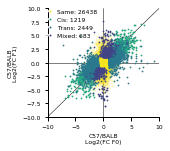

In [13]:
fig, ax = plt.subplots(figsize=(2,2))

# plot bounding lines
ax.plot([-10,10], [-10,10], c='k',
        linewidth=0.5, zorder=1)
ax.axhline(0, c='k', linewidth=0.5,
           zorder=1)
ax.axvline(0, c='k', linewidth=0.5,
           zorder=1)

ax.scatter(df.loc[:, f0_log2fc_col],
          -df.loc[:, f1_log2fc_col],
           s=0.5,
           c=[viridis(0.99)],
           alpha = 0.2,
           rasterized=True,
           zorder=2)

for peaklist, color in zip(lists, colors):
    ax.scatter(df.loc[peaklist, f0_log2fc_col],
               -df.loc[peaklist, f1_log2fc_col],
               s=0.5,
               c=[color],
               rasterized=True,
               zorder=3)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('C57/BALB\nLog2(FC F0)')
ax.set_ylabel('C57/BALB\nLog2(FC F1)')

ax.legend(handles=legend_elements,
          fontsize=6,
          frameon=False, ncol=1, loc=(-0.05,0.7),
          handletextpad=0.05, columnspacing=0.05)

ax.set_xlim([-10,10]);
ax.set_ylim([-10,10]);


plt.savefig('./figures/cis_trans_tyMethod.pdf',
            bbox_inches='tight')

One giant issue with this plot is that we get contamination with peaks that are not significant but have a high estimated fold change...

In [14]:
for label, peaklist in zip(labels, lists):
    df.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/h3k27ac_'+label+'.txt',
        sep='\t')
    df_distal.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/h3k27ac_'+label+'_distal.txt',
        sep='\t')

# Log2FC only, then p value

In [15]:
parental_balb = (df[f0_log2fc_col] < -fc)
parental_c57 = (df[f0_log2fc_col] > fc)

f1_balb = (df[f1_log2fc_col] > fc)
f1_c57 = (df[f1_log2fc_col]  < -fc)

In [16]:
cis_balb = parental_balb & f1_balb & ((df[f0_padj_col] < 0.05) & (df[f1_padj_col] < 0.05))
trans_balb = parental_balb & (~f1_balb) & (df[f0_padj_col] < 0.05)
mixed_balb = (~parental_balb) & (f1_balb) & (df[f1_padj_col] < 0.05)

cis_c57 = parental_c57 & f1_c57 & ((df[f0_padj_col] < 0.05) & (df[f1_padj_col] < 0.05))
trans_c57 = parental_c57 & (~f1_c57) & (df[f0_padj_col] < 0.05)
mixed_c57 = (~parental_c57) & (f1_c57) & (df[f1_padj_col] < 0.05)

prepare plot

In [17]:
lists = [cis_balb, trans_balb, mixed_balb,
         cis_c57, trans_c57, mixed_c57]
labels = ['cis_balb_tyMethodFiltPval', 'trans_balb_tyMethodFiltPval', 'mixed_balb_tyMethodFiltPval',
          'cis_c57_tyMethodFiltPval', 'trans_c57_tyMethodFiltPval', 'mixed_c57_tyMethodFiltPval']

viridis = matplotlib.cm.get_cmap('viridis')
colors = [viridis(0.6), viridis(0.4), viridis(0.2),
          viridis(0.6), viridis(0.4), viridis(0.2)]

# create objects for legend
# calculate total cis / trans / mixed
n_cis = cis_balb.sum() + cis_c57.sum()
n_trans = trans_balb.sum() + trans_c57.sum()
n_mixed = mixed_balb.sum() + mixed_c57.sum()
n_same = df.shape[0] - (n_cis + n_trans + n_mixed)

In [18]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],
                          marker='o', color='w',
                          label='Same: %i' % n_same,
                          markerfacecolor=viridis(0.99),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Cis: %i' % n_cis,
                          markerfacecolor=viridis(0.6),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Trans: %i' % n_trans,
                          markerfacecolor=viridis(0.4),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Mixed: %i' % n_mixed,
                          markerfacecolor=viridis(0.2),
                          markersize=3)]

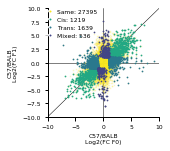

In [19]:
fig, ax = plt.subplots(figsize=(2,2))

# plot bounding lines
ax.plot([-10,10], [-10,10], c='k',
        linewidth=0.5, zorder=1)
ax.axhline(0, c='k', linewidth=0.5,
           zorder=1)
ax.axvline(0, c='k', linewidth=0.5,
           zorder=1)

ax.scatter(df.loc[:, f0_log2fc_col],
          -df.loc[:, f1_log2fc_col],
           s=0.5,
           c=[viridis(0.99)],
           alpha = 0.2,
           zorder=2,
           rasterized=True)

for peaklist, color in zip(lists, colors):
    ax.scatter(df.loc[peaklist, f0_log2fc_col],
               -df.loc[peaklist, f1_log2fc_col],
               s=0.5,
               c=[color],
               zorder=3,
               rasterized=True)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('C57/BALB\nLog2(FC F0)')
ax.set_ylabel('C57/BALB\nLog2(FC F1)')

ax.legend(handles=legend_elements,
          fontsize=6,
          frameon=False, ncol=1, loc=(-0.05,0.7),
          handletextpad=0.05, columnspacing=0.05)

ax.set_xlim([-10,10]);
ax.set_ylim([-10,10]);

plt.savefig('./figures/cis_trans_tyMethodFiltPval.pdf',
            bbox_inches='tight')

In [20]:
for label, peaklist in zip(labels, lists):
    df.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/h3k27ac_'+label+'.txt',
        sep='\t')
    df_distal.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/h3k27ac_'+label+'_distal.txt',
        sep='\t')

# Log2FC only

In [21]:
# flip sign of f1 for cis.

# cis: difference of f0 and f1 is less than 1 log2fc, also require that at least one has a log2fc > 1
cis = (np.abs(df.loc[:,f0_log2fc_col] - (-df.loc[:,f1_log2fc_col])) < 1) & (np.abs(df.loc[:,f0_log2fc_col]) > 1)

# trans: not cis, abs(f0 log2fc) > 1, abs(f1 log2fc) < 1
trans = ((~cis) & ((np.abs(df.loc[:,f0_log2fc_col])>1) & ((np.abs(df.loc[:,f1_log2fc_col]) < 1))) )

# mixed: not cis or trans, abs(f0 log2fc) < 1, abs(f1 log2fc) > 1
mixed = ( (~cis) & ((~trans) & ((np.abs(df.loc[:,f0_log2fc_col]) < 1) & (np.abs(df.loc[:,f1_log2fc_col]) > 1))) )

In [22]:
print(cis.sum())
print(trans.sum())
print(mixed.sum())

3318
1932
4733


In [23]:
lists = [cis, trans, mixed]
labels = ['cis', 'trans', 'mixed']
colors = [viridis(0.6), viridis(0.4), viridis(0.2)]

n_cis = cis.sum()
n_trans = trans.sum()
n_mixed = mixed.sum()
n_same = df.shape[0] - (n_cis + n_trans + n_mixed)

In [24]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],
                          marker='o', color='w',
                          label='Same: %i' % n_same,
                          markerfacecolor=viridis(0.99),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Cis: %i' % n_cis,
                          markerfacecolor=viridis(0.6),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Trans: %i' % n_trans,
                          markerfacecolor=viridis(0.4),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Mixed: %i' % n_mixed,
                          markerfacecolor=viridis(0.2),
                          markersize=3)]

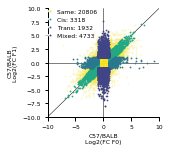

In [25]:
fig, ax = plt.subplots(figsize=(2,2))

# plot bounding lines
ax.plot([-10,10], [-10,10], c='k',
        linewidth=0.5, zorder=1)
ax.axhline(0, c='k', linewidth=0.5,
           zorder=1)
ax.axvline(0, c='k', linewidth=0.5,
           zorder=1)

ax.scatter(df.loc[:, f0_log2fc_col],
          -df.loc[:, f1_log2fc_col],
           s=0.5,
           c=[viridis(0.99)],
           alpha = 0.2,
           rasterized=True,
           zorder=2)

for peaklist, color in zip(lists, colors):
    ax.scatter(df.loc[peaklist, f0_log2fc_col],
               -df.loc[peaklist, f1_log2fc_col],
               s=0.5,
               c=[color],
               rasterized=True,
               zorder=3)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('C57/BALB\nLog2(FC F0)')
ax.set_ylabel('C57/BALB\nLog2(FC F1)')

ax.legend(handles=legend_elements,
          fontsize=6,
          frameon=False, ncol=1, loc=(-0.05,0.7),
          handletextpad=0.05, columnspacing=0.05)

ax.set_xlim([-10,10]);
ax.set_ylim([-10,10]);

plt.savefig('./figures/cis_trans_hunterFCOnly.pdf',
            bbox_inches='tight')

### Extract strain specific info

In [26]:
# cis
cis_balb = (cis) & (df[f0_log2fc_col] < -fc)
cis_c57 = (cis) & (df[f0_log2fc_col] > fc)

# trans
trans_balb = (trans) & (df[f0_log2fc_col] < -fc)
trans_c57 = (trans) & (df[f0_log2fc_col] > fc)

# flipped sign for f1
mixed_balb = (mixed) & (df[f1_log2fc_col] > fc)
mixed_c57 = (mixed) & (df[f1_log2fc_col] < -fc)

In [27]:
lists = [cis_balb, cis_c57, trans_balb, trans_c57, mixed_balb, mixed_c57]
labels = ['cis_balb_hunterFCOnly', 'cis_c57_hunterFCOnly',
          'trans_balb_hunterFCOnly', 'trans_c57_hunterFCOnly',
          'mixed_balb_hunterFCOnly', 'mixed_c57_hunterFCOnly']

In [28]:
for label, peaklist in zip(labels, lists):
    df.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/h3k27ac_'+label+'.txt',
        sep='\t')
    df_distal.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/h3k27ac_'+label+'_distal.txt',
        sep='\t')

# Can we filter these subsets by pvalue?
* trans should be specific using F0 adjusted p-value
* mixed should be specific using F1 adjusted p-value

In [40]:
# flip sign of f1 for cis.

sig_f0 = (df[f0_padj_col] < 0.05)
sig_f1 = (df[f1_padj_col] < 0.05)
sig_both = (sig_f1 & sig_f0)

# cis: difference of f0 and f1 is less than 1 log2fc, also require that at least one has a log2fc > 1
cis = ((np.abs(df.loc[:,f0_log2fc_col] - (-df.loc[:,f1_log2fc_col])) < 1) & ((np.abs(df.loc[:,f0_log2fc_col]) > 1) & sig_both) )

# trans: not cis, abs(f0 log2fc) > 1, abs(f1 log2fc) < 1
trans = ((~cis) & ((np.abs(df.loc[:,f0_log2fc_col])>1) & ((np.abs(df.loc[:,f1_log2fc_col]) < 1))) & sig_f0 )

# mixed: not cis or trans, abs(f0 log2fc) < 1, abs(f1 log2fc) > 1
mixed = ( (~cis) & ((~trans) & ((np.abs(df.loc[:,f0_log2fc_col]) < 1) & (np.abs(df.loc[:,f1_log2fc_col]) > 1))) & sig_f1 )

In [41]:
print(cis.sum())
print(trans.sum())
print(mixed.sum())

936
1493
533


In [43]:
lists = [cis, trans, mixed]
labels = ['cis', 'trans', 'mixed']
colors = [viridis(0.6), viridis(0.4), viridis(0.2)]

n_cis = cis.sum()
n_trans = trans.sum()
n_mixed = mixed.sum()
n_same = df.shape[0] - (n_cis + n_trans + n_mixed)

In [44]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],
                          marker='o', color='w',
                          label='Same: %i' % n_same,
                          markerfacecolor=viridis(0.99),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Cis: %i' % n_cis,
                          markerfacecolor=viridis(0.6),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Trans: %i' % n_trans,
                          markerfacecolor=viridis(0.4),
                          markersize=3),
                   Line2D([0], [0],
                          marker='o', color='w',
                          label='Mixed: %i' % n_mixed,
                          markerfacecolor=viridis(0.2),
                          markersize=3)]

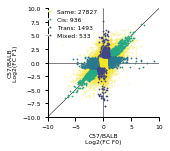

In [45]:
fig, ax = plt.subplots(figsize=(2,2))

# plot bounding lines
ax.plot([-10,10], [-10,10], c='k',
        linewidth=0.5, zorder=1)
ax.axhline(0, c='k', linewidth=0.5,
           zorder=1)
ax.axvline(0, c='k', linewidth=0.5,
           zorder=1)

ax.scatter(df.loc[:, f0_log2fc_col],
          -df.loc[:, f1_log2fc_col],
           s=0.5,
           c=[viridis(0.99)],
           alpha = 0.25,
            rasterized=True,
           zorder=2)

for peaklist, color in zip(lists, colors):
    ax.scatter(df.loc[peaklist, f0_log2fc_col],
               -df.loc[peaklist, f1_log2fc_col],
               s=0.5,
               c=[color],
               rasterized=True,
               zorder=3)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('C57/BALB\nLog2(FC F0)')
ax.set_ylabel('C57/BALB\nLog2(FC F1)')

ax.legend(handles=legend_elements,
          fontsize=6,
          frameon=False, ncol=1, loc=(-0.05,0.7),
          handletextpad=0.05, columnspacing=0.05)

ax.set_xlim([-10,10]);
ax.set_ylim([-10,10]);

plt.savefig('./figures/cis_trans_hunterFCThenPadj.pdf',
            bbox_inches='tight')

In [34]:
# cis
cis_balb = (cis) & (df[f0_log2fc_col] < -fc)
cis_c57 = (cis) & (df[f0_log2fc_col] > fc)

# trans
trans_balb = (trans) & (df[f0_log2fc_col] < -fc)
trans_c57 = (trans) & (df[f0_log2fc_col] > fc)

# flipped sign for f1
mixed_balb = (mixed) & (df[f1_log2fc_col] > fc)
mixed_c57 = (mixed) & (df[f1_log2fc_col] < -fc)

In [35]:
lists = [cis_balb, cis_c57, trans_balb, trans_c57, mixed_balb, mixed_c57]
labels = ['cis_balb_hunterFCThenPadj', 'cis_c57_hunterFCThenPadj',
          'trans_balb_hunterFCThenPadj', 'trans_c57_hunterFCThenPadj',
          'mixed_balb_hunterFCThenPadj', 'mixed_c57_hunterFCThenPadj']

In [36]:
for label, peaklist in zip(labels, lists):
    df.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/h3k27ac_'+label+'.txt',
        sep='\t')
    df_distal.loc[peaklist, :].astype(convert_dict).iloc[:, :5].to_csv(
        './motif_calling/h3k27ac_'+label+'_distal.txt',
        sep='\t')

# Write out scripts for running HOMER
- since this was annotated with a size of 1000 bp we need to resize the peaks in homer to 200 bp (since they are annotated on ATAC-seq IDr peaks)

In [37]:
strain_dict = {'c57': 'c57bl6j',
               'balb': 'balbcj',
               'aj': 'aj'}

# background set all peaks that were considered as differential
all_peaks = './peakQuan/allPeaksF1F0.txt' 
all_peaks_distal = './peakQuan/allPeaksF1F0_distal.txt' 

with open('./findMotifs_differential_mixed.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./motif_calling/h3k27ac*mixed*.txt')):
        strain = peakfile.split('/')[-1].split('_')[2]
        if 'distal' in peakfile:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks_distal, '-size 200',
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        else:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks, '-size 200',
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))

In [38]:
strain_dict = {'c57': 'c57bl6j',
               'balb': 'balbcj',
               'aj': 'aj'}

# background set all peaks that were considered as differential
all_peaks = './peakQuan/allPeaksF1F0.txt' 
all_peaks_distal = './peakQuan/allPeaksF1F0_distal.txt' 

with open('./findMotifs_differential_cis.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./motif_calling/h3k27ac*cis*.txt')):
        strain = peakfile.split('/')[-1].split('_')[2]
        if 'distal' in peakfile:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks_distal, '-size 200',
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        else:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks, '-size 200',
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))

In [39]:
strain_dict = {'c57': 'c57bl6j',
               'balb': 'balbcj',
               'aj': 'aj'}

# background set all peaks that were considered as differential
all_peaks = './peakQuan/allPeaksF1F0.txt' 
all_peaks_distal = './peakQuan/allPeaksF1F0_distal.txt' 

with open('./findMotifs_differential_trans.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./motif_calling/h3k27ac*trans*.txt')):
        strain = peakfile.split('/')[-1].split('_')[2]
        if 'distal' in peakfile:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks_distal, '-size 200',
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        else:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks, '-size 200',
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))